# Reproducing results from Pahitariu et al. 2024

In [1]:
# Imports
import sys

sys.path.append("../../stork")

import stork

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change default color cycler
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cm.batlow(np.linspace(0, 1, 10)))


from utils.utils import *

from scipy.stats import linregress
from sklearn.decomposition import PCA

from pydmd.plotter import plot_modes_2D
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

using spikeinit stork


In [2]:
# for reproducibility
np.random.seed(2025)

In [20]:
# Simulation parameters
dt = timestep = 2e-3  # timestep in s
duration = 60  # Duration in seconds
epsilon_calc_method = (
    "numerical"  # Choose between numerical or analytical way of computing epsilon
)

nb_steps = int(duration / dt)
tau = 5e-3

N = 2500

symmetric = False

In [21]:
# LIF parameters
tau_syn = 10e-3
tau_mem = 20e-3
theta = 1.0  # threshold
refractory_period = 2e-3  # refractory period in s

dcy_mem = float(np.exp(-timestep / tau_mem))
scl_mem = 1.0 - dcy_mem
dcy_syn = float(np.exp(-timestep / tau_syn))
scl_syn = 1.0 - dcy_syn


In [98]:
# Initialization target parameters
mu_U = 0.0  # Target mean of membrane potential distribution
xi = 1.0  # Target distance between membrane potential mean (mu_U) and firing threshold (1.0)
# in units of standard deviation
alpha = 0.9
nu = 1  # presynaptic firing rate

mu_w, sigma_w = get_w_params(
    N=N,
    nu=nu,
    theta=theta,
    mu_U=mu_U,
    xi=xi,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    eps_calc_mode=epsilon_calc_method)

weights = np.stack([sample_normal(N, mu_w, sigma_w) for i in range(N)])

In [99]:
print(np.mean(weights))

9.122223812499152e-05


## Analyse weight matrix

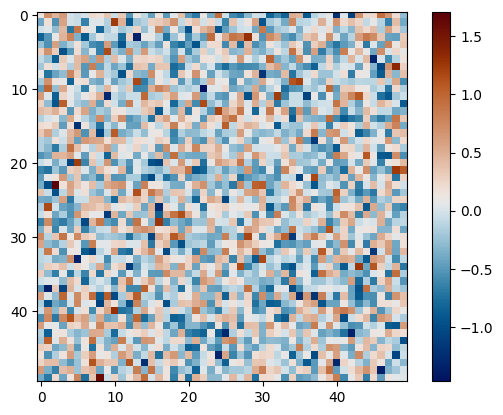

In [100]:
im = plt.imshow(weights[:50, :50], cmap=cm.vik)
plt.colorbar(im)

In [101]:
eig_w = np.linalg.eigvals(weights)

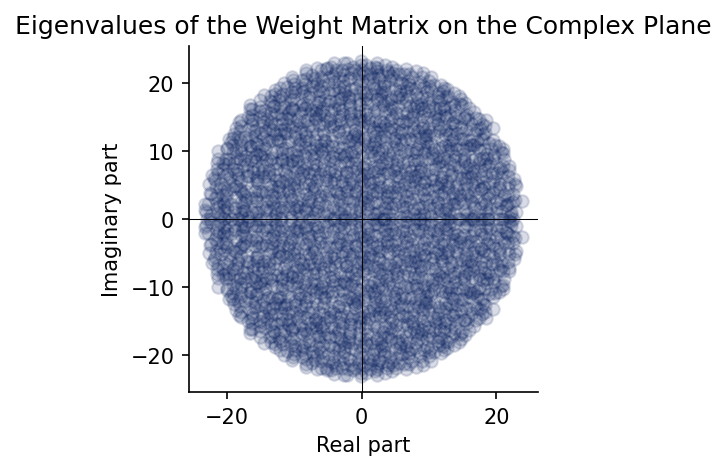

In [102]:
plt.figure(figsize=(3, 3), dpi=150)

if symmetric:
    plt.hist(eig_w, edgecolor="white", alpha=0.75, bins=30, density=True)
    plt.xlabel("eig w")
    plt.ylabel("density")

else:
    # Plot the eigenvalues on the complex plane
    plt.scatter(eig_w.real, eig_w.imag, alpha=0.15, edgecolor=None)
    plt.axhline(0, color="black", lw=0.5)
    plt.axvline(0, color="black", lw=0.5)
    plt.xlabel("Real part")
    plt.ylabel("Imaginary part")
    plt.title("Eigenvalues of the Weight Matrix on the Complex Plane")

sns.despine()
plt.show()

## Run dynamics

$\dot{I } = -1/\tau_s I + AS +\epsilon$  
$\tau_m \dot{U} = - U + I +\epsilon$  
$S = \sigma(U)$


In [103]:
def get_spike_and_reset(mem):
    mthr = mem - 1.0
    out = np.heaviside(mthr, 1)

    return out

In [104]:
mem_seq = [np.zeros(N)]
syn_seq = [np.zeros(N)]
out_seq = [np.zeros(N)]


for t in trange(int(duration // timestep)):
    epsilon = np.random.normal(size=N) * dt / tau

    inp_rec = out_seq[-1] @ weights * (1 - alpha)

    # spike & reset
    new_out = get_spike_and_reset(mem_seq[-1])

    # synaptic & membrane dynamics
    new_syn = dcy_syn * syn_seq[-1] + epsilon + inp_rec
    new_mem = (dcy_mem * mem_seq[-1] + scl_mem * syn_seq[-1]) * (1.0 - new_out)  # multiplicative reset
    # new_mem = -mem_seq[-1] * dcy_syn + inp_rec + inp_ff

    new_mem = np.clip(new_mem, a_max=1.01, a_min=-np.inf)

    mem_seq.append(new_mem)
    syn_seq.append(new_syn)
    out_seq.append(new_out)

100%|██████████| 29999/29999 [02:30<00:00, 198.70it/s]


In [105]:
mem_seq = np.stack(mem_seq)
syn_seq = np.stack(syn_seq)
out_seq = np.stack(out_seq)
print(mem_seq.shape)

(30000, 2500)


discard first few time steps of the states

In [106]:
orig_states = out_seq
states = orig_states.copy()

In [107]:
print(states.shape)
n_discard = 8000
states = states[n_discard:]
print(states.shape)

(30000, 2500)
(22000, 2500)


In [108]:
# # normalize activity
# states = (states - np.mean(states))*2/(np.max(states)-np.min(states))

# print(np.min(states), np.max(states))

# print(states.shape)
# for i, state in enumerate(states.T):
#     states[:, i] =(state-np.mean(state))/np.std(state)

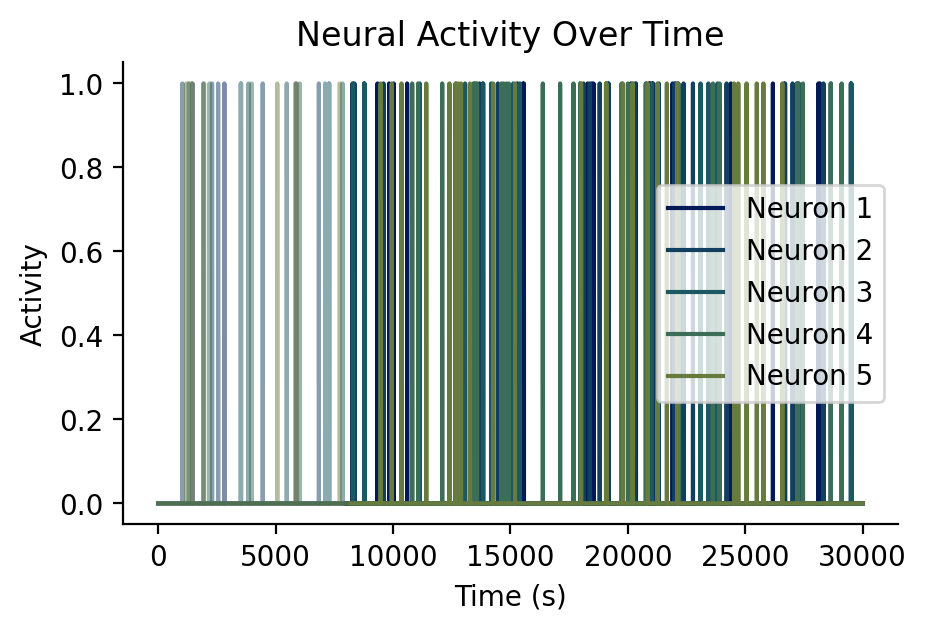

In [109]:
# Plot the first few neurons' activity over time
plt.figure(figsize=(5, 3), dpi=200)
for i in range(5):
    plt.plot(np.arange(n_discard, nb_steps), states[:, i], label=f"Neuron {i+1}")

# reset color cycler
plt.gca().set_prop_cycle(None)
for i in range(5):
    plt.plot(np.arange(n_discard), orig_states[:n_discard, i],  alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Activity")
plt.title("Neural Activity Over Time")
plt.legend()
sns.despine()
plt.show()

0.00108008


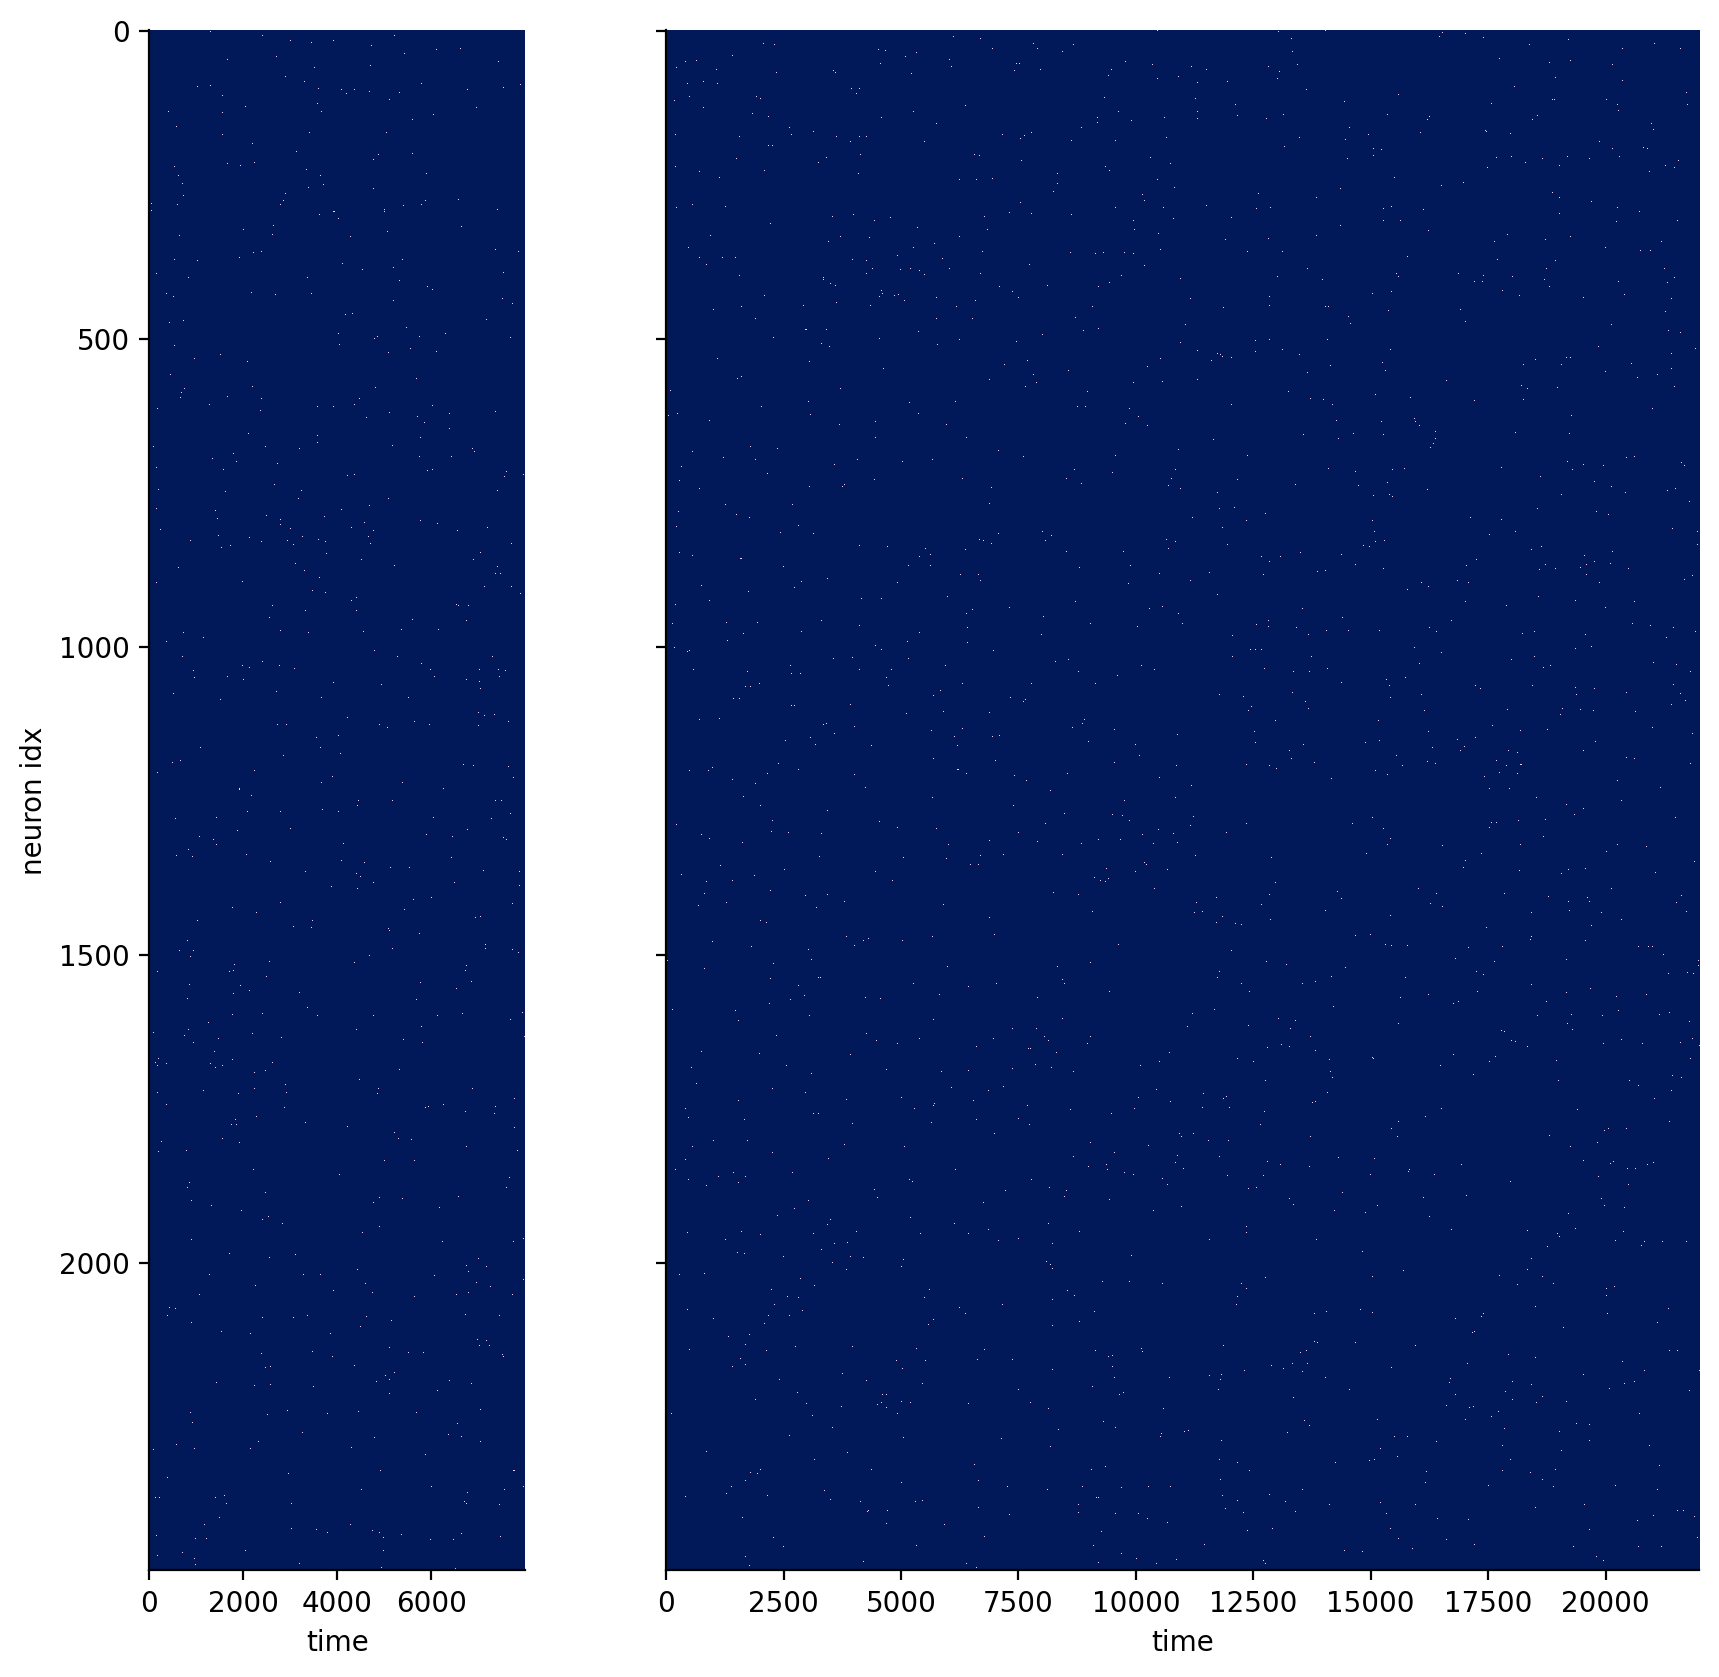

In [110]:
fig, ax = plt.subplots(1,2,figsize=(10,10), dpi=200, gridspec_kw={"width_ratios": [n_discard, nb_steps-n_discard]}, sharey=True)
ax[0].imshow(orig_states[:n_discard].T, aspect="auto", cmap=cm.batlow, interpolation="nearest")
ax[1].imshow(states.T, aspect="auto", cmap=cm.batlow, interpolation="nearest")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[0].set_ylabel("neuron idx")
sns.despine()

print(np.mean(orig_states))

In [111]:
print(states.shape)

(22000, 2500)


In [112]:
if False:
    # https://pydmd.github.io/PyDMD/tutorial1dmd.html


    d = 2
    neuron_space = np.linspace(0, N+1, N)
    time_space = np.linspace(0, nb_steps+1, nb_steps)
    print(neuron_space)

    # Build the Optimized DMD model.
    # num_trials=0 gives Optimized DMD, without bagging.
    optdmd = BOPDMD(svd_rank=20, num_trials=0)

    # Wrap the model with the preprocessing routine.
    delay_optdmd = hankel_preprocessing(optdmd, d=d)

    # Fit the model to the noisy data.
    # Note: BOPDMD models need the data X and the times of data collection t for fitting.
    # Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
    delay_t = time_space[: -d + 1]
    delay_optdmd.fit(states.T, t=delay_t)

    # Plot a summary of the DMD results.
    plot_summary(delay_optdmd, x=neuron_space, d=d)

    # Print computed eigenvalues (frequencies are given by imaginary components).
    # Also plot the resulting data reconstruction.
    print(
        f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
    )
    plt.title("Reconstructed Data")
    plt.imshow(delay_optdmd.reconstructed_data.real)
    plt.show()
    plt.title("Clean Ground Truth Data")
    plt.imshow(states.T)
    plt.show()

/home/gygajuli/miniconda3/envs/stork/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'dpi'
  cset = contour_func(


Text(12.722222222222223, 0.5, 'Neuron 2')

<Figure size 400x400 with 0 Axes>

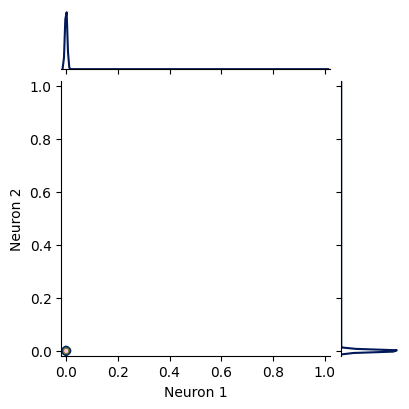

In [113]:
# Create a DataFrame for seaborn
data = {"Neuron 1": states[:, 0], "Neuron 2": states[:, 1]}
df = pd.DataFrame(data)

# Plot the density plot
plt.figure(figsize=(4, 4))
sns.jointplot(
    x=data["Neuron 1"],
    y=data["Neuron 2"],
    kind="kde",
    cmap=cm.batlow,
    height=4,
    ratio=4,
    dpi=250,
    palette=cm.batlow,
)

plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")

22 Hz sampling from data that is simulated at 500 Hz

In [114]:
# Define the bin size
bin_size = 22

# Calculate the number of bins
num_bins = states.shape[0] // bin_size

# Initialize the binned states array
binned_states = np.zeros((num_bins, states.shape[1]))

# Bin the states
for i in range(num_bins):
    binned_states[i] = np.mean(states[i*bin_size:(i+1)*bin_size], axis=0)

print(binned_states.shape)

(1000, 2500)


In [115]:
# Define the bin size
bin_size = 22

# Calculate the number of bins
num_bins = states.shape[0] // bin_size

# Initialize the binned states array
binned_states = np.zeros((num_bins, states.shape[1]))

# Bin the states
for i in range(num_bins):
    binned_states[i] = np.mean(states[i*bin_size:(i+1)*bin_size], axis=0)

print(binned_states.shape)

(1000, 2500)


In [116]:
ds_states = states.copy()
ds_states = ds_states[::22]

print(ds_states.shape)

(1000, 2500)


In [117]:
activity = binned_states

Text(0, 0.5, 'neuron')

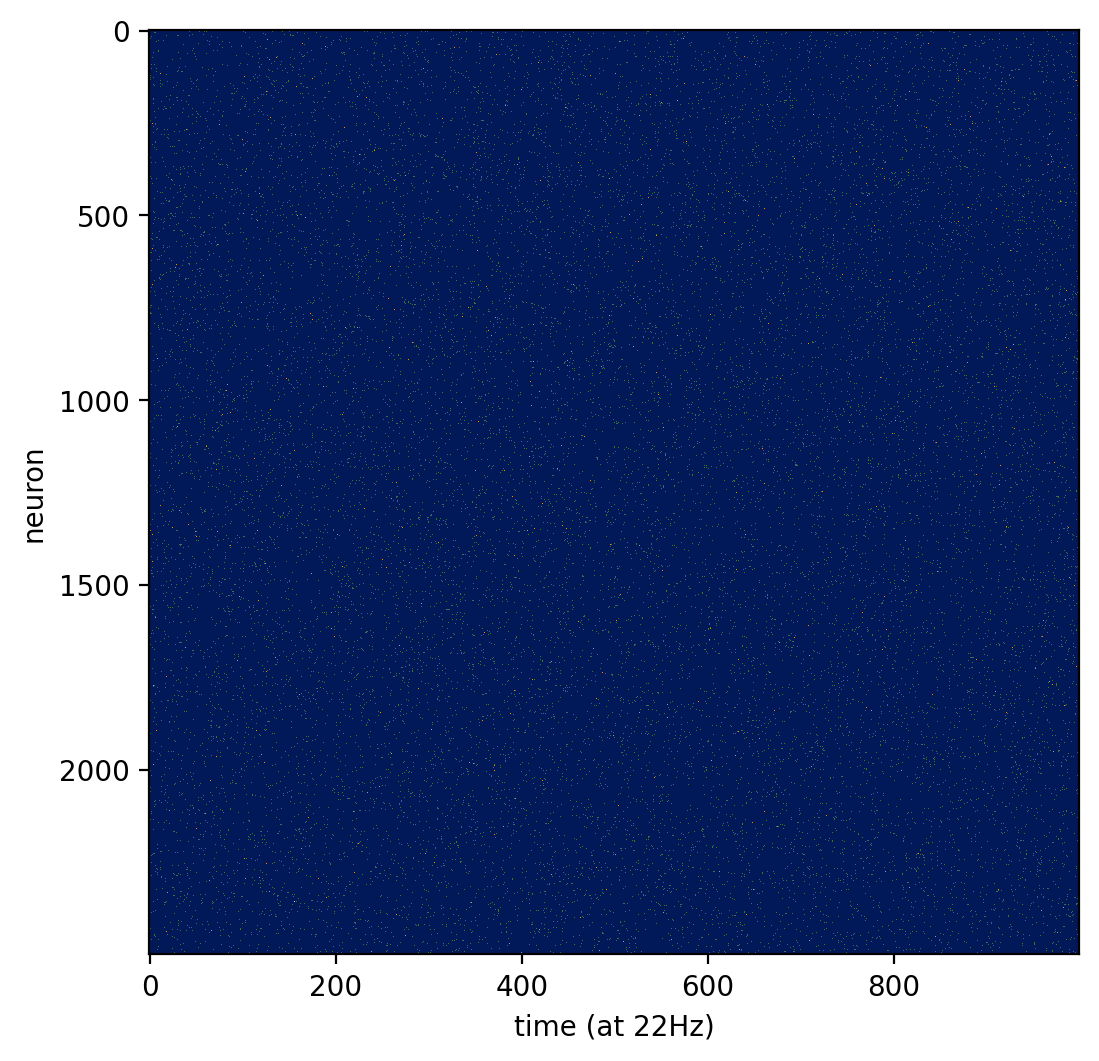

In [118]:
plt.figure(figsize=(6,6), dpi=200)
plt.imshow(activity.T, aspect="auto", interpolation="nearest", cmap=cm.batlow)
plt.xlabel("time (at 22Hz)")
plt.ylabel("neuron")

In [119]:
cov_matrix = np.cov(activity.T)

print(cov_matrix.shape)

(2500, 2500)


In [120]:
eig_cov = sorted(np.linalg.eigvals(cov_matrix), reverse=True)

In [125]:
# Estimate power law exponent

# Select the range of eigenvalues
rank_range = np.arange(10, 101)
log_rank = np.log(rank_range)
log_eig_cov = np.log(eig_cov[9:100])

# Perform weighted linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_eig_cov)

# The slope of the regression line is the power-law exponent
power_law_exponent = slope
print(f"Estimated power-law exponent: {power_law_exponent}")

Estimated power-law exponent: (-0.12162133943458414+0j)


In [126]:
# theory: power law
x = np.arange(N)

sym = x**-0.69
asym = x**-1.3
simulated = x**power_law_exponent

/tmp/ipykernel_174893/1507369407.py:4: RuntimeWarning: divide by zero encountered in power
  sym = x**-0.69
/tmp/ipykernel_174893/1507369407.py:5: RuntimeWarning: divide by zero encountered in power
  asym = x**-1.3
/tmp/ipykernel_174893/1507369407.py:6: RuntimeWarning: invalid value encountered in power
  simulated = x**power_law_exponent


In [127]:
scaled_eig_cov = eig_cov /eig_cov[10]*simulated[10]

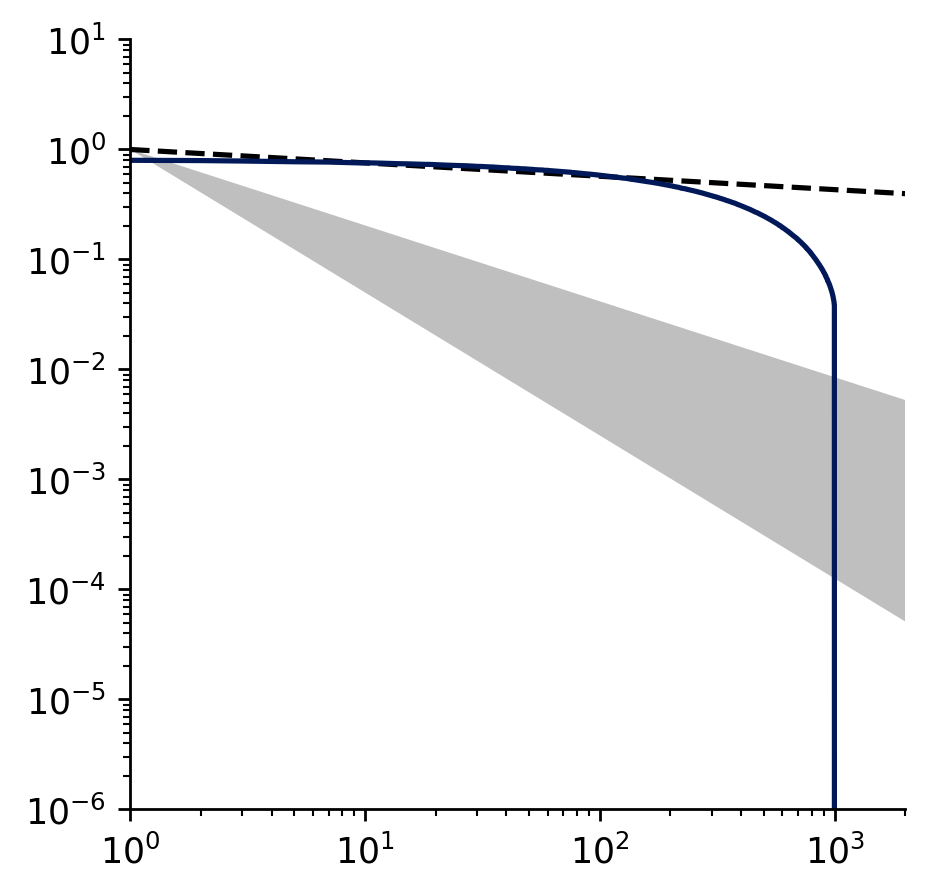

In [128]:
plt.figure(figsize=(4, 4), dpi=250)
plt.loglog(x, simulated, label="fit", ls="--", color="k")
plt.loglog(x, scaled_eig_cov, label="simulation", )

plt.fill_between(x, asym, sym, color="gray", alpha=0.5, edgecolor=None)

plt.xlim(1, 2000)
plt.ylim(0.000001, 10)

sns.despine()